In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
class LeafScoreDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['score'], dtype=torch.float32)
        return image, label

In [4]:
# ✅ Step 3: Load Data & Prepare Transforms
# Update these paths
csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)/Healthy (1)'

df = pd.read_csv(csv_path)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = LeafScoreDataset(train_df, image_dir, transform)
val_ds = LeafScoreDataset(val_df, image_dir, transform)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [5]:
# ✅ Step 4: Define the Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Regression head
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s]


In [6]:
# ✅ Step 5: Train & Validate Functions
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        preds = model(x)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x).squeeze()
            preds.extend(output.cpu().numpy())
            targets.extend(y.cpu().numpy())
    return np.array(preds), np.array(targets)


In [7]:
import os
os.path.exists('/content/drive/MyDrive/arch/wheat_leaf (1)/Healthy (1)/loh(94).JPG')

#!find /content/drive/ -name 'loh(94).JPG'


True

In [8]:
# ✅ Step 6: Run Training
for epoch in range(10):
    train_loss = train(model, train_loader)
    preds, targets = validate(model, val_loader)
    mae = np.mean(np.abs(preds - targets))
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val MAE = {mae:.2f}")


Epoch 1: Train Loss = 75.5413, Val MAE = 7.50
Epoch 2: Train Loss = 62.2438, Val MAE = 6.83
Epoch 3: Train Loss = 44.0896, Val MAE = 5.74
Epoch 4: Train Loss = 46.3876, Val MAE = 5.16
Epoch 5: Train Loss = 37.7950, Val MAE = 4.46
Epoch 6: Train Loss = 31.7047, Val MAE = 3.59
Epoch 7: Train Loss = 25.2800, Val MAE = 2.92
Epoch 8: Train Loss = 18.8170, Val MAE = 2.59
Epoch 9: Train Loss = 16.5587, Val MAE = 2.28
Epoch 10: Train Loss = 12.9920, Val MAE = 2.03


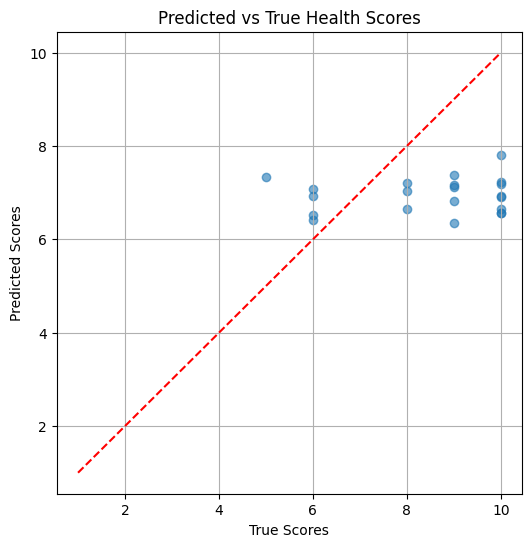

In [9]:
# ✅ Step 7: Visualization
plt.figure(figsize=(6,6))
plt.scatter(targets, preds, alpha=0.6)
plt.plot([1, 10], [1, 10], 'r--')
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs True Health Scores")
plt.grid(True)
plt.show()

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import umap


print("\nGenerating UMAP for labeled dataset...")

# Combine train and val for UMAP
combined_df = pd.concat([train_df, val_df]).reset_index(drop=True)
combined_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Reuse feature extractor from trained model
feature_extractor = models.resnet34(pretrained=True)
modules = list(feature_extractor.children())[:-1]
feature_extractor = nn.Sequential(*modules).to(device)
feature_extractor.eval()

features = []
scores = []

with torch.no_grad():
    for i in range(len(combined_df)):
        row = combined_df.iloc(i)
        img_path = os.path.join(image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        image = combined_transform(image).unsqueeze(0).to(device)
        feat = feature_extractor(image).squeeze().cpu().numpy()
        features.append(feat)
        scores.append(row['score'])

features = np.vstack(features)
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=scores, cmap='plasma', s=40)
plt.colorbar(scatter, label='True Health Score')
plt.title('UMAP Projection of Labeled Leaf Images by True Score')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.show()



Generating UMAP for labeled dataset...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: Cannot index by location index with a non-integer key